# Coordinate reference systems

In [2]:
%matplotlib inline

!pip install geopandas
import pandas as pd
import geopandas

     |████████████████████████████████| 1.0 MB 6.6 MB/s 
     |████████████████████████████████| 15.4 MB 49.9 MB/s 
     |████████████████████████████████| 6.3 MB 31.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
countries = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/geopandas-tutorial-master/data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/geopandas-tutorial-master/data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/geopandas-tutorial-master/data/ne_50m_rivers_lake_centerlines.zip")

## Coordinate reference systems

Up to now, we have used the geometry data with certain coordinates without further wondering what those coordinates mean or how they are expressed.

> The **Coordinate Reference System (CRS)** relates the coordinates to a specific location on earth.

For a nice in-depth explanation, see https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

### Geographic coordinates

> Degrees of latitude and longitude.
>
> E.g. 48°51′N, 2°17′E

The most known type of coordinates are geographic coordinates: we define a position on the globe in degrees of latitude and longitude, relative to the equator and the prime meridian. 
With this system, we can easily specify any location on earth. It is used widely, for example in GPS. If you inspect the coordinates of a location in Google Maps, you will also see latitude and longitude.

**Attention!**

in Python we use (lon, lat) and not (lat, lon)

- Longitude: [-180, 180]{{1}}
- Latitude: [-90, 90]{{1}}

### Projected coordinates

> `(x, y)` coordinates are usually in meters or feet

Although the earth is a globe, in practice we usually represent it on a flat surface: think about a physical map, or the figures we have made with Python on our computer screen.
Going from the globe to a flat map is what we call a *projection*.

![](img/projection.png)

We project the surface of the earth onto a 2D plane so we can express locations in cartesian x and y coordinates, on a flat surface. In this plane, we then typically work with a length unit such as meters instead of degrees, which makes the analysis more convenient and effective.

However, there is an important remark: the 3 dimensional earth can never be represented perfectly on a 2 dimensional map, so projections inevitably introduce distortions. To minimise such errors, there are different approaches to project, each with specific advantages and disadvantages.

Some projection systems will try to preserve the area size of geometries, such as the Albers Equal Area projection. Other projection systems try to preserve angles, such as the Mercator projection, but will see big distortions in the area. Every projection system will always have some distortion of area, angle or distance.

<table><tr>
<td> <img src="img/projections-AlbersEqualArea.png"/> </td>
<td> <img src="img/projections-Mercator.png"/> </td>
</tr>
<tr>
<td> <img src="img/projections-Robinson.png"/> </td>
</tr></table>

**Projected size vs actual size (Mercator projection)**:

![](img/mercator_projection_area.gif)

## Coordinate Reference Systems in Python / GeoPandas

A GeoDataFrame or GeoSeries has a `.crs` attribute which holds (optionally) a description of the coordinate reference system of the geometries:

In [5]:
countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

For the `countries` dataframe, it indicates that it uses the EPSG 4326 / WGS84 lon/lat reference system, which is one of the most used for geographic coordinates.


It uses coordinates as latitude and longitude in degrees, as can you be seen from the x/y labels on the plot:

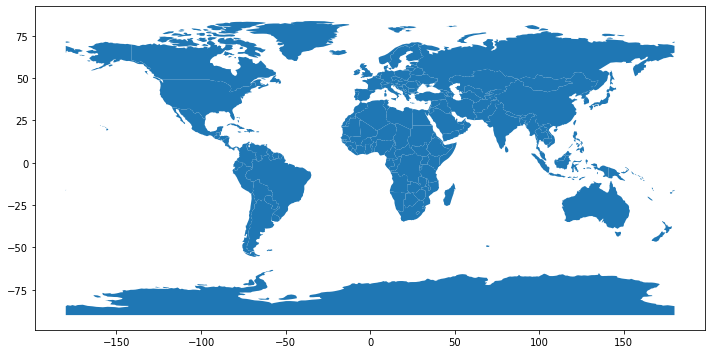

In [8]:
countries.plot(figsize=(12,6))

The `.crs` attribute is given as a dictionary. In this case, it only indicates the EPSG code, but it can also contain the full "proj4" string (in dictionary form).

Possible CRS representation:

- **`proj4` string**  
  
  Example: `+proj=longlat +datum=WGS84 +no_defs`

  Or its dict representation: `{'proj': 'longlat', 'datum': 'WGS84', 'no_defs': True}`

- **EPSG code**
  
  Example: `EPSG:4326` = WGS84 geographic CRS (longitude, latitude)
  
- Well-Know-Text (WKT) representation (better support coming with PROJ6 in the next GeoPandas version)

See eg https://epsg.io/4326

Under the hood, GeoPandas uses the `pyproj` / `PROJ` libraries to deal with the re-projections.

For more information, see also http://geopandas.readthedocs.io/en/latest/projections.html.

### Transforming to another CRS

We can convert a GeoDataFrame to another reference system using the `to_crs` function. 

For example, let's convert the countries to the World Mercator projection (http://epsg.io/3395):

In [9]:
# remove Antartica, as the Mercator projection cannot deal with the poles
countries = countries[(countries['name'] != "Antarctica")]

In [10]:
countries_mercator = countries.to_crs(epsg=3395)  # or .to_crs({'init': 'epsg:3395'})

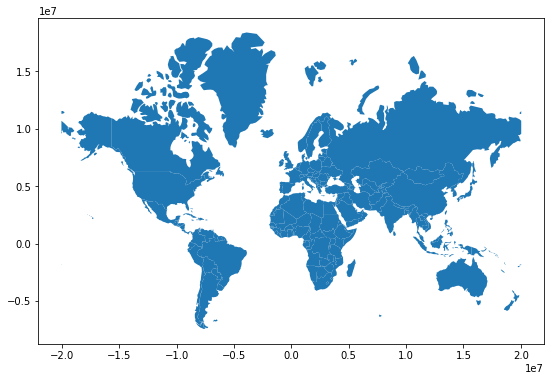

In [12]:
countries_mercator.plot(figsize=(12,6))

Note the different scale of x and y.

### Why using a different CRS?

There are sometimes good reasons you want to change the coordinate references system of your dataset, for example:

- Different sources with different CRS -> need to convert to the same crs

    ```python
    df1 = geopandas.read_file(...)
    df2 = geopandas.read_file(...)

    df2 = df2.to_crs(df1.crs)
    ```

- Mapping (distortion of shape and distances)

- Distance / area based calculations -> ensure you use an appropriate projected coordinate system expressed in a meaningful unit such as metres or feet (not degrees).

<div class="alert alert-info" style="font-size:120%">

**ATTENTION:**

All the calculations that happen in geopandas and shapely assume that your data is in a 2D cartesian plane, and thus the result of those calculations will only be correct if your data is properly projected.

</div>

## Let's practice!

Again, we will go back to the Paris datasets. Up to now, we provided the datasets in an appropriate projected CRS for the exercises. But the original data actually were geographic coordinates. In the following exercises, we will start from there.

---

Going back to the Paris districts dataset, this is now provided as a GeoJSON file (`"data/paris_districts.geojson"`) in geographic coordinates.

For converting to projected coordinates, we will use the standard projected CRS for France is the RGF93 / Lambert-93 reference system, referenced by the `EPSG:2154` number (in Belgium this would be Lambert 72, EPSG:31370).

<div class="alert alert-success">

**EXERCISE: Projecting a GeoDataFrame**

* Read the districts datasets (`"data/paris_districts.geojson"`) into a GeoDataFrame called `districts`.
* Look at the CRS attribute of the GeoDataFrame. Do you recognize the EPSG number?
* Make a simple plot of the `districts` dataset.
* Calculate the area of all districts.
* Convert the `districts` to a projected CRS (using the `EPSG:2154` for France). Call the new dataset `districts_RGF93`.
* Make a similar plot of `districts_RGF93`.
* Calculate the area of all districts again with `districts_RGF93` (the result will now be expressed in m²).
    
    
<details><summary>Hints</summary>

* The CRS information is stored in the `crs` attribute of a GeoDataFrame.
* Making a simple plot of a GeoDataFrame can be done with the `.plot()` method.
* Converting to a different CRS can be done with the `to_crs()` method, and the CRS can be specified as an EPSG number using the `epsg` keyword.

</details>

</div>

In [22]:
# %load _solved/solutions/02-coordinate-reference-systems1.py
disctricts =geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/geopandas-tutorial-master/data/paris_districts.geojson")
disctricts

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ..."
1,2,Halles,8984,"POLYGON ((2.34937 48.86058, 2.34822 48.85852, ..."
2,3,Palais-Royal,3195,"POLYGON ((2.33947 48.86214, 2.33912 48.86148, ..."
3,4,Place-Vendôme,3044,"POLYGON ((2.33194 48.86491, 2.33135 48.86399, ..."
4,5,Gaillon,1345,"POLYGON ((2.33632 48.86797, 2.33587 48.86700, ..."
...,...,...,...,...
75,76,Combat,38988,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
76,77,Belleville,35773,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
77,78,Saint-Fargeau,42087,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."
78,79,Père-Lachaise,42332,"POLYGON ((2.39536 48.85670, 2.39444 48.85657, ..."


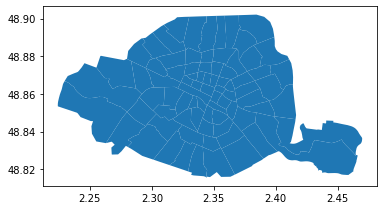

In [14]:
# %load _solved/solutions/02-coordinate-reference-systems2.py
disctricts.plot()

In [ ]:
# %load _solved/solutions/02-coordinate-reference-systems3.py

In [23]:
# %load _solved/solutions/02-coordinate-reference-systems4.py
disctricts.geometry.area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


0     0.000107
1     0.000051
2     0.000034
3     0.000033
4     0.000023
        ...   
75    0.000159
76    0.000099
77    0.000182
78    0.000196
79    0.000256
Length: 80, dtype: float64

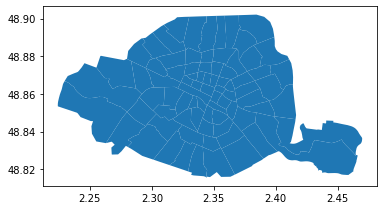

In [19]:
# %load _solved/solutions/02-coordinate-reference-systems5.py
disctricts_2154 = disctricts.to_crs(epsg=2154) 
disctricts.plot()

In [24]:
disctricts_2154.geometry.area

0     8.690007e+05
1     4.124585e+05
2     2.736968e+05
3     2.694568e+05
4     1.880122e+05
          ...     
75    1.294988e+06
76    8.065686e+05
77    1.486971e+06
78    1.599002e+06
79    2.090904e+06
Length: 80, dtype: float64

In [ ]:
# %load _solved/solutions/02-coordinate-reference-systems6.py

In [ ]:
# %load _solved/solutions/02-coordinate-reference-systems7.py

In [ ]:
# %load _solved/solutions/02-coordinate-reference-systems8.py

<div class="alert alert-success">

**EXERCISE:**

In the first notebook, we did an exercise on plotting the bike stations locations in Paris and adding a background map to it using the `contextily` package.

Currently, `contextily` assumes that your data is in the Web Mercator projection, the system used by most web tile services. And in that first exercise, we provided the data in the appropriate CRS so you didn't need to care about this aspect.

However, typically, your data will not come in Web Mercator (`EPSG:3857`) and you will have to align them with web tiles on your own.
    
* Read the bike stations datasets (`"data/paris_bike_stations.geojson"`) into a GeoDataFrame called `stations`.
* Convert the `stations` dataset to the Web Mercator projection (`EPSG:3857`). Call the result `stations_webmercator`, and inspect the result.
* Make a plot of this projected dataset (specify the marker size to be 5) and add a background map using `contextily`.

    
<details><summary>Hints</summary>

* Making a simple plot of a GeoDataFrame can be done with the `.plot()` method. This returns a matplotlib axes object.
* The marker size can be specified with the `markersize` keyword if the `plot()` method.
* To add a background map, use the `contextily.add_basemap()` function. It takes the matplotlib `ax` to which to add a map as the first argument.

</details>

</div>

In [26]:
# %load _solved/solutions/02-coordinate-reference-systems9.py
stations = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/geopandas-tutorial-master/data/paris_bike_stations.geojson")
stations

,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (2.32956 48.83920)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (2.40591 48.84772)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (2.40517 48.85550)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (2.43737 48.85770)
4,43006 - MINIMES (VINCENNES),28,27,POINT (2.43079 48.84149)
...,...,...,...,...
1221,12011 - CHARENTON,36,35,POINT (2.38258 48.84487)
1222,13110 - MOULIN DE LA POINTE,22,4,POINT (2.35635 48.82104)
1223,07006 - QUAI VOLTAIRE,32,25,POINT (2.33142 48.85894)
1224,21311 - GAMBETTA (ISSY LES MOULINEAUX),55,47,POINT (2.27855 48.82747)


In [32]:
# %load _solved/solutions/02-coordinate-reference-systems10.py
stations_webmercator = stations.to_crs(epsg=3857) 
print(stations_webmercator.crs)
stations_webmercator 

epsg:3857


,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (259324.887 6247620.771)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (267824.377 6249062.894)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (267742.135 6250378.469)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (271326.638 6250750.824)
4,43006 - MINIMES (VINCENNES),28,27,POINT (270594.689 6248007.705)
...,...,...,...,...
1221,12011 - CHARENTON,36,35,POINT (265227.474 6248579.501)
1222,13110 - MOULIN DE LA POINTE,22,4,POINT (262307.142 6244549.880)
1223,07006 - QUAI VOLTAIRE,32,25,POINT (259532.287 6250960.774)
1224,21311 - GAMBETTA (ISSY LES MOULINEAUX),55,47,POINT (253646.981 6245637.291)


In [29]:
!pip install contextily

     |████████████████████████████████| 19.3 MB 391 kB/s 


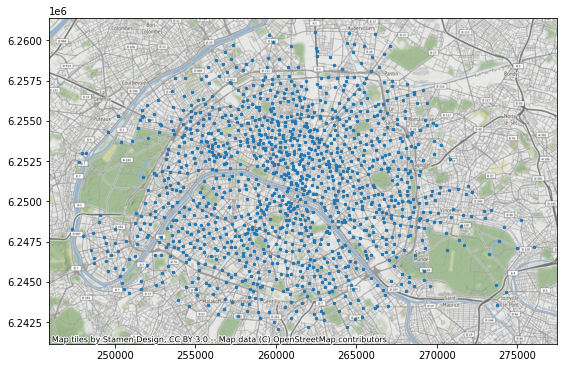

In [33]:
# %load _solved/solutions/02-coordinate-reference-systems11.py
import contextily 
ax = stations_webmercator.plot(figsize=(12,6), markersize = 6)
contextily.add_basemap(ax)